In [44]:
import pandas as pd
import geopandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import random
from scipy import stats
from scipy import integrate
import glob
import seaborn as sns
# %matplotlib notebook
%matplotlib inline
from brokenaxes import brokenaxes
import matplotlib.ticker as ticker

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

from fitter import Fitter, get_common_distributions, get_distributions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### CoomoditiesRealPrices: annual prices, 1960 to present, real 2010 US dollars

In [2]:
ComoditiesRealPrices = pd.read_csv('RealPricesCommodities'+'.csv', sep=",", header=[0,1],index_col=0)
ComoditiesRealPrices.columns = ComoditiesRealPrices.columns.map('_'.join)
ComoditiesRealPrices = ComoditiesRealPrices.rename_axis('Year')
ComoditiesRealPrices

,"Crude oil, average_($/bbl)","Crude oil, Brent_($/bbl)","Crude oil, Dubai_($/bbl)","Crude oil, WTI_($/bbl)","Coal, Australian_($/mt)","Coal, South Afican_($/mt)","Natural gas, US_($/mmbtu)","Natural gas, Europe_($/mmbtu)","Liquefied natural gas, Japan_($/mmbtu)",Natural gas index_(2010=100),Cocoa_($/kg),"Coffee, Arabica_($/kg)","Coffee, Robusta_($/kg)","Tea, avg 3 auctions_($/kg)","Tea, Colombo_($/kg)","Tea, Kolkata_($/kg)","Tea, Mombasa_($/kg)",Coconut oil_($/mt),Groundnuts_($/mt),Fish meal_($/mt),Groundnut oil_($/mt),Palm oil_($/mt),Palm kernel oil_($/mt),Soybeans_($/mt),Soybean oil_($/mt),Soybean meal_($/mt),Barley_($/mt),Maize_($/mt),Sorghum_($/mt),"Rice, Thai 5% _($/mt)","Rice, Thai 25% _($/mt)","Rice, Thai A.1_($/mt)","Rice, Viet Namese 5%_($/mt)","Wheat, US SRW_($/mt)","Wheat, US HRW_($/mt)","Banana, Europe_($/kg)","Banana, US_($/kg)",Orange_($/kg),Beef_($/kg),"Meat, chicken_($/kg)","Meat, sheep_($/kg)","Shrimps, Mexican_($/kg)","Sugar, EU_($/kg)","Sugar, US_($/kg)","Sugar, world_($/kg)","Tobacco, US import u.v._($/mt)","Logs, Cameroon_($/cubic meter)","Logs, Malaysian_($/cubic meter)","Sawnwood, Cameroon_($/cubic meter)","Sawnwood, Malaysian_($/cubic meter)",Plywood_(¢/sheet),"Cotton, A Index_($/kg)","Rubber, TSR20_($/kg)","Rubber, SGP/MYS_($/kg)",Phosphate rock_($/mt),DAP_($/mt),TSP_($/mt),Urea _($/mt),Potassium chloride_($/mt),Aluminum_($/mt),"Iron ore, cfr spot_($/dmtu)",Copper_($/mt),Lead_($/mt),Tin_($/mt),Nickel_($/mt),Zinc_($/mt),Gold_($/troy oz),Platinum_($/troy oz),Silver_($/troy oz),MUV Index_(2010=100)
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1960,8.51,..,8.51,..,..,..,0.73,2.11,..,18.93,3.08,4.82,3.64,5.38,4.86,5.86,5.42,1631.60,..,..,1708.22,1172.33,..,479.73,1169.72,423.18,105.28,232.46,191.06,560.78,..,..,..,..,302.95,..,0.75,0.68,3.85,1.57,..,8.39,0.64,0.66,0.35,9073.26,..,166.85,..,779.28,..,3.42,..,4.08,67.91,0.00,276.87,220.71,148.88,2671.88,59.66,3545.76,1038.78,11475.54,8520.20,1286.08,184.25,436.20,4.77,19.14
1961,8.05,..,8.05,..,..,..,0.77,2.07,..,19.19,2.45,4.59,3.43,4.88,4.57,5.01,5.04,1298.56,..,..,1692.27,1170.46,..,560.25,1472.36,496.58,106.32,230.37,212.23,609.53,..,..,..,..,300.31,..,0.69,0.68,3.49,1.60,..,8.68,0.64,0.64,0.30,8010.13,..,169.41,..,778.76,..,3.44,..,3.08,66.61,0.00,266.46,216.50,153.73,2620.89,56.47,3244.06,906.86,12553.78,8767.54,1098.16,180.63,427.87,4.74,19.52
1962,7.65,..,7.65,..,..,..,0.80,2.04,..,19.45,2.30,4.19,3.43,4.89,4.33,5.56,4.80,1263.71,..,..,1380.03,1087.74,..,505.75,1141.89,447.74,114.20,244.74,224.86,678.72,..,..,..,..,323.62,..,0.66,0.54,3.59,1.61,..,11.33,0.64,0.65,0.31,7067.14,..,183.05,..,805.16,..,3.27,..,2.84,57.85,0.00,256.55,212.53,150.91,2505.42,55.38,3245.30,781.13,12431.93,8858.45,935.27,177.22,420.03,5.45,19.88
1963,7.69,..,7.69,..,..,..,0.82,2.01,..,19.49,2.83,4.13,3.19,4.88,4.18,5.55,4.92,1467.23,..,..,1375.87,1139.59,..,564.14,1145.69,466.39,122.87,275.53,245.14,643.93,..,..,..,..,330.44,..,0.74,0.48,3.41,1.68,..,10.23,0.65,0.85,0.94,6884.95,..,181.84,..,808.85,..,3.31,..,2.67,58.93,0.00,266.46,216.50,153.73,2555.94,56.47,3309.99,895.76,12850.18,8924.68,1083.82,179.81,414.71,6.55,19.52
1964,7.33,..,7.33,..,..,..,0.76,1.94,..,18.43,2.56,5.10,3.98,4.68,4.14,5.25,4.66,1498.24,..,..,1593.75,1210.07,..,558.44,1177.46,449.80,127.06,276.08,243.76,607.16,..,..,..,..,341.25,..,0.86,0.42,4.25,1.71,..,9.16,0.64,0.70,0.64,7521.12,..,152.89,..,731.92,..,3.29,..,2.48,63.17,0.00,267.84,305.74,164.24,2658.07,51.75,4900.64,1404.28,17246.28,8801.51,1649.92,177.38,447.14,6.53,19.79
1965,7.11,..,7.11,..,..,..,0.80,2.06,..,19.50,1.83,5.01,3.39,5.01,4.24,5.72,5.07,1752.54,..,..,1621.32,1364.07,..,584.97,1351.44,485.64,121.85,278.66,239.91,594.58,..,..,..,..,297.63,..,0.80,0.48,4.41,1.75,..,9.95,0.62,0.68,0.22,6333.82,..,175.31,..,784.58,..,3.19,..,2.53,70.07,0.00,270.29,329.10,147.66,2703.55,53.37,6471.13,1587.57,19474.72,8684.28,1557.91,175.79,490.73,6.47,19.98
1966,6.57,..,6.57,..,..,..,0.77,2.05,..,19.13,2.50,4.48,3.57,4.22,3.67

In [3]:
P2O5Content_dict = {'P rock min':0.28,
                    'P rock max':0.34,
                    'DAP':0.46,
                    'TSP':0.45,
                   }

P2O5toP = 0.436

PContent_dict = P2O5Content_dict
PContent_dict.update({n: P2O5toP * PContent_dict[n] for n in PContent_dict.keys()})

PContent_dict

{'P rock min': 0.12208000000000001,
 'P rock max': 0.14824,
 'DAP': 0.20056000000000002,
 'TSP': 0.1962}

In [6]:
ComoditiesRealPrices_Pcontent =pd.DataFrame()

InflactionAdjustment2020 = 1.19 #https://www.census.gov/topics/income-poverty/income/guidance/current-vs-constant-dollars.html

ComoditiesRealPrices_Pcontent['P rock min (EUR/kg P)'] = ComoditiesRealPrices['Phosphate rock_($/mt)']/1000/PContent_dict['P rock min']*InflactionAdjustment2020
ComoditiesRealPrices_Pcontent['P rock max (EUR/kg P)'] = ComoditiesRealPrices['Phosphate rock_($/mt)']/1000/PContent_dict['P rock max']*InflactionAdjustment2020
ComoditiesRealPrices_Pcontent['DAP (EUR/kg P)'] = ComoditiesRealPrices['DAP_($/mt)']/1000/PContent_dict['DAP']*InflactionAdjustment2020
ComoditiesRealPrices_Pcontent['TSP (EUR/kg P)'] = ComoditiesRealPrices['TSP_($/mt)']/1000/PContent_dict['TSP']*InflactionAdjustment2020

ComoditiesRealPrices_Pcontent = ComoditiesRealPrices_Pcontent[ComoditiesRealPrices_Pcontent.index >= 1980]

ComoditiesRealPrices_Pcontent.to_csv('ComoditiesRealPrices_Pcontent.csv')

ComoditiesRealPrices_Pcontent

,P rock min (EUR/kg P),P rock max (EUR/kg P),DAP (EUR/kg P),TSP (EUR/kg P)
Year,,,,
1980,0.667523,0.549725,2.021386,1.676129
1981,0.730883,0.601904,1.614000,1.498539
1982,0.660992,0.544346,1.560540,1.325134
1983,0.629117,0.518096,1.626697,1.324345
1984,0.534369,0.440069,1.727624,1.319796
1985,0.587884,0.484140,1.562379,1.233366
1986,0.511170,0.420963,1.194153,1.070515
1987,0.442448,0.364369,1.261913,1.112608
1988,0.384450,0.316606,1.334359,1.199037


In [56]:
Results_df = pd.read_csv('../Results/PRecoveryAndCosts/Results_PlotSummary.csv', sep=",", header=0, index_col=0)
Results_df.loc['Total recoverable P'] = Results_df.sum(axis=0)


Avg_PRecoveryPrice_S1 = (Results_df.loc['Total recoverable P']['Minimum recovery cost (EUR/year)']/
Results_df.loc['Total recoverable P']['Minimum P recovered (kg P/year)'])

Avg_PRecoveryPrice_S2 = (Results_df.loc['Total recoverable P']['Maximum recovery cost (EUR/year)']/
Results_df.loc['Total recoverable P']['Maximum P recovered (kg P/year)'])

Avg_PRecoveryPrice_S1

35.83317252179859

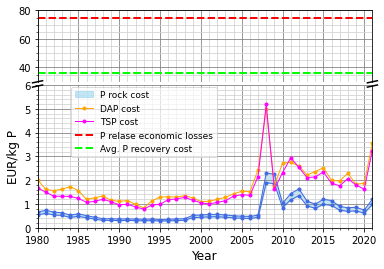

In [85]:
# fig, ax = plt.subplots(1, 1, figsize=(7.5,7.5),)

ylim  = [30, 80]
ylim2 = [0, 6]
# ylimratio = (ylim[1]-ylim[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
# ylim2ratio = (ylim2[1]-ylim2[0])/(ylim2[1]-ylim2[0]+ylim[1]-ylim[0])
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2])
fig = plt.figure()
ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

# padding = 0.6
# my_range1=np.arange(1,(len(Results_PlotSummary.index))*2,2)
# my_range11=[i+padding for i in my_range1]
# my_range2=np.arange(2,(len(Results_PlotSummary.index)+1)*2,2)

# plot the same data on both axes
linewidth=1
markersize=3

ax.plot(ComoditiesRealPrices_Pcontent.index, ComoditiesRealPrices_Pcontent['P rock min (EUR/kg P)'],
       color='royalblue', linewidth=linewidth, alpha=1, linestyle='solid',#(0,(1,1)), 
        marker='o', markerfacecolor='royalblue', markersize=markersize,)

ax.plot(ComoditiesRealPrices_Pcontent.index, ComoditiesRealPrices_Pcontent['P rock max (EUR/kg P)'],
       color='royalblue', linewidth=linewidth, alpha=1, linestyle='solid',#(0,(1,1)), 
        marker='o', markerfacecolor='royalblue', markersize=markersize,)

ax.fill_between(
    ComoditiesRealPrices_Pcontent.index,
    ComoditiesRealPrices_Pcontent['P rock min (EUR/kg P)'], ComoditiesRealPrices_Pcontent['P rock max (EUR/kg P)'],
    # where=(income > expenses), 
    interpolate=True, color="skyblue", alpha=0.5, 
    label="P rock cost"
)

ax.plot(ComoditiesRealPrices_Pcontent.index, ComoditiesRealPrices_Pcontent['DAP (EUR/kg P)'],
       color='orange', linewidth=linewidth, alpha=1, linestyle='solid',#(0,(1,1)), 
        marker='o', markerfacecolor='orange', markersize=markersize, label="DAP cost")

ax.plot(ComoditiesRealPrices_Pcontent.index, ComoditiesRealPrices_Pcontent['TSP (EUR/kg P)'],
       color='magenta', linewidth=linewidth, alpha=1, linestyle='solid',#(0,(1,1)), 
        marker='o', markerfacecolor='magenta', markersize=markersize, label="TSP cost")

ax.hlines(74.5, xmin=ComoditiesRealPrices_Pcontent.index.min(), xmax=ComoditiesRealPrices_Pcontent.index.max(),
          color='red', linewidth=2, alpha=1, linestyle='dashed', label="P relase economic losses")

ax.hlines(Avg_PRecoveryPrice_S1, xmin=ComoditiesRealPrices_Pcontent.index.min(), xmax=ComoditiesRealPrices_Pcontent.index.max(),
          color='lime', linewidth=2, alpha=1, linestyle='dashed')
ax.hlines(Avg_PRecoveryPrice_S2, xmin=ComoditiesRealPrices_Pcontent.index.min(), xmax=ComoditiesRealPrices_Pcontent.index.max(),
          color='lime', linewidth=2, alpha=1, linestyle='dashed', label="Avg. P recovery cost")

# ax.fill_between(
#     ComoditiesRealPrices_Pcontent.index,
#     Avg_PRecoveryPrice_S1, Avg_PRecoveryPrice_S2,
#     # where=(income > expenses), 
#     interpolate=True, color="lime", alpha=0.5, 
#     label="Avg. P recovery cost"
# )


####################################33

ax2.plot(ComoditiesRealPrices_Pcontent.index, ComoditiesRealPrices_Pcontent['P rock min (EUR/kg P)'],
       color='royalblue', linewidth=linewidth, alpha=1, linestyle='solid',#(0,(1,1)), 
        marker='o', markerfacecolor='royalblue', markersize=markersize,)

ax2.plot(ComoditiesRealPrices_Pcontent.index, ComoditiesRealPrices_Pcontent['P rock max (EUR/kg P)'],
       color='royalblue', linewidth=linewidth, alpha=1, linestyle='solid',#(0,(1,1)), 
        marker='o', markerfacecolor='royalblue', markersize=markersize,)

ax2.fill_between(
    ComoditiesRealPrices_Pcontent.index,
    ComoditiesRealPrices_Pcontent['P rock min (EUR/kg P)'], ComoditiesRealPrices_Pcontent['P rock max (EUR/kg P)'],
    # where=(income > expenses), 
    interpolate=True, color="skyblue", alpha=0.5, 
    #label="P rock cost"
)

ax2.plot(ComoditiesRealPrices_Pcontent.index, ComoditiesRealPrices_Pcontent['DAP (EUR/kg P)'],
       color='orange', linewidth=linewidth, alpha=1, linestyle='solid',#(0,(1,1)), 
        marker='o', markerfacecolor='orange', markersize=markersize,)# label="DAP cost")

ax2.plot(ComoditiesRealPrices_Pcontent.index, ComoditiesRealPrices_Pcontent['TSP (EUR/kg P)'],
       color='magenta', linewidth=linewidth, alpha=1, linestyle='solid',#(0,(1,1)), 
        marker='o', markerfacecolor='magenta', markersize=markersize,)# label="TSPcost ")

ax2.hlines(74.5, xmin=ComoditiesRealPrices_Pcontent.index.min(), xmax=ComoditiesRealPrices_Pcontent.index.max(),
          color='red', linewidth=2, alpha=1, linestyle='dashed',)# label="P relase economic losses")

ax2.hlines(Avg_PRecoveryPrice_S1, xmin=ComoditiesRealPrices_Pcontent.index.min(), xmax=ComoditiesRealPrices_Pcontent.index.max(),
          color='lime', linewidth=2, alpha=1, linestyle='dashed',) #label="Avg. P recovery cost")
ax2.hlines(Avg_PRecoveryPrice_S2, xmin=ComoditiesRealPrices_Pcontent.index.min(), xmax=ComoditiesRealPrices_Pcontent.index.max(),
          color='lime', linewidth=2, alpha=1, linestyle='dashed')

# ax2.fill_between(
#     ComoditiesRealPrices_Pcontent.index,
#     Avg_PRecoveryPrice_S1, Avg_PRecoveryPrice_S2,
#     # where=(income > expenses), 
#     interpolate=True, color="lime", alpha=0.5, 
#     label="Avg. P recovery cost"
# )

# zoom-in / limit the view to different portions of the data
# ax.set_ylim(2.5E8, 1E9)  # outliers only
# ax2.set_ylim(0, 1E8)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
# ax.xaxis.tick_top()
# ax.tick_params(labeltop='off')  # don't put tick labels at the top
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
ax2.xaxis.tick_bottom()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 ), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 ), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'
ax.set_ylim(ylim)
ax2.set_ylim(ylim2)
fig.subplots_adjust(hspace=0.03)

ax.set_xlim([ComoditiesRealPrices_Pcontent.index.min(),ComoditiesRealPrices_Pcontent.index.max()])
ax2.set_xlim([ComoditiesRealPrices_Pcontent.index.min(),ComoditiesRealPrices_Pcontent.index.max()])


ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())


ax.grid(axis='x',which='major', color='grey', linestyle='-')
ax.grid(axis='x',which='minor', color='lightgrey', linestyle='-')
ax.grid(axis='y',which='major', color='grey', linestyle='-')
ax.grid(axis='y',which='minor', color='lightgrey', linestyle='-')

ax2.grid(axis='x',which='major', color='grey', linestyle='-')
ax2.grid(axis='x',which='minor', color='lightgrey', linestyle='-')
ax2.grid(axis='y',which='major', color='grey', linestyle='-')
ax2.grid(axis='y',which='minor', color='lightgrey', linestyle='-')

fig.legend(bbox_to_anchor=(0.55,0.63), prop={'size':9}, framealpha=0.7)

ax2.set_ylabel("EUR/kg P", fontsize=12)
ax2.set_xlabel("Year", fontsize=12)



plt.savefig('CommodityPrices.pdf', bbox_inches='tight',)
